In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
setting_generation_prompt_template = \
'''We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment and outcome variable) and no causal parents
- mediator variables may or may not be observable, and should always have at least one causal parent (for example, a treatment variable) and at least one causal child (for example, the outcome variable)
- collider variables may or may not be observable, and should always have at least two causal parents (for example, a treatment and outcome variable) and no causal children

Answer concisely and precisely in the desired format. Carefully complete each of these tasks in order.

1. Write a short description of what the article is about and what causal model make inform the reasoning behind an argument the might make.
2. Propose 1 outcome variable that the news article is either implicitly or explicitly addressing that people are most likely to be interested in studying, especially if people tend to have misconceptions about it
3. Propose 2 treatment variables that either directly or indirectly affect the selected outcome variable and are the most interesting to study
4. Propose 4 confounder variables that affect some reasonable combination of the outcome and treatment variables
5. Propose 3 mediator variables that affect and are affected by some reasonable combination of any other variables
6. Propose 2 collider variables that are affected by some reasonable combination of any other variables

Here is the beginning of the news article:
```
{spark}
```

The variables and causal graph should, where possible, use specific details such as names and locations mentioned in the article. Also, generally the variable value "0" should correspond to the negative, neutral, or control while the value "1" should correspond to the positive choice or active value.

Take a deep breath and think step-by-step about how you will do this.'''
graph_selection_prompt_template = \
'''1. Select some combination of 3-5 of the suggested confounder, mediator, and collider variables, in addition to the treatment and outcome variables to construct a realistic and interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than three parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a python list of the names of the parents of the variable (make sure they match the corresponding `name` field of the parent nodes, and remember, there should not be more than three parents for any node)

Take a deep breath and think step-by-step about how you will do this.'''
stats_prompt_template = \
'''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

{prob_questions}

Where the variables are defined as:
{descriptions}

For each question above, answer with the lower and upper bound estimates of the probabilities as a python dictionary where the key corresponds to the question index in exactly the following format:

```python
probabilities = {{
  1: [0.3, 0.4],
  ...
}}
```

Answer concisely and precisely in the desired format.'''
verb_prompt_template = \
'''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {{variable}}.
2. We estimate {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
3. There is a [number]% chance that {{value}}.
4. [number]% of {{domain}} {{value}}.
5. [number]% of the time {{value}}.
6. Conditional sentence: {{value}}, [some consequence].
7. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. When replacing the key "value", make sure to include some examples for both values that the variables can take. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate"=0 and "High Smoking Rate"=1 can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    1: {{"variable": ["the smoking rate", "proportion of smokers"]}},
    2: {{"subject": "people", "value": {{0: ["do not smoke", "are non-smokers"], 1: ["smoke", "are smokers"]}}}},
    3: {{"value": {{0: ["people do not smoke", "people are non-smokers"], 1: ["people smoke", "people are smokers"]}}}},
    4: {{"domain": "people", "value": {{0: ["do not smoke", "are non-smokers"], 1: ["smoke", "are smokers"]}}}},
    5: {{"value": {{0: ["the smoking rate decreases", "people stop smoking"], 1: ["the smoking rate increases", "people start smoking"]}}}},
    6: {{"value": {{0: ["For people that do not smoke", "Among non-smokers"], 1: ["For people that smoke", "Among smokers"]}}}},
    7: {{"value": {{0: ["people quite smoking", "people become non-smokers"], 1: ["people become smokers", "people take up smoking"]}}}},
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''
question_prompt_template = \
'''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to use this model to generate some interesting research questions:

1. Write a short two sentence introduction to describe motivation and purpose of the causal model to provide context to the questions in an conversational/debate setting. Where possible, include relevant details from the original article headline or related information you can infer therefrom. Avoid discussing specific structural properties or assumptions in the causal graph, and instead focus on the overall motivation and potential applications for the model. Refrain from mentioning words like "causal inference" or "model".
Make sure not to use any technical terms from causal inference so that the introduction is easy to understand even for a layperson, as if this were in a newspaper or casual discussion.
2. Write a short two sentence overview of the structure of the causal graph including noteworthy properties and assumptions. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "confounder"/"confounding", "mediator"/"mediates") as long as you explain them in a way that is understandable to a layperson.
3. Verbalize an interesting "yes"/"no" question where the correct answer depends computation of each of the following quantities:

{query_description}

Where "| * |" is the absolute value and the definitions of "ATE('X')" (average treatment effect) and "CATE('X' | 'U'=u)" are:

ATE('X') = E['Y' | do('X' = 1)] - E['Y' | do('X' = 0)]
CATE('X' | 'U'=u) = E['Y' | 'U'=u, do('X' = 1)] - E['Y' | 'U'=u, do('X' = 0)]

Where 'X' is a treatment variable, 'Y' is the outcome variable, and 'U' is a confounder variable.

4. In addition to the questions and associated answers include a one sentence explanation for each question, and "wrong_explanation" which is just like the explanation but argues for the opposite answer.

The meanings of all the variables (all of which are binary) in the statistical model are:

{variable_description}

Answer in the form of a python dictionary in the following format:

```python
setting = {{
  "introduction": "[introduction]",
  "overview": "[overview]",
  "questions": {{
    1: {{"question": "[question]", "answer": "yes", "explanation": "[explanation]", "wrong_explanation": "[wrong_explanation]"}},
    ...
  }},
}}
```
Answer concisely and precisely in the desired format. Do not add any additional comments or discussion. Most importantly, do not use any technical terms from causal inference such as ATE or CATE in the questions and explanations so that everything is easy to understand even for a layperson.'''

In [23]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories')
ctx.populate_defaults(story_prompt_tempalte=setting_generation_prompt_template,
                      graph_prompt_template=graph_selection_prompt_template,
                      stats_prompt_template=stats_prompt_template,
                        verb_prompt_template=verb_prompt_template,
                        questions_prompt_template=question_prompt_template,
                      )
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

805971
Title: Municipality of Rotterdam regarding Feyenoord City: 'Scenario taken into account when Feyenoord withdraws' - FR-Fans.nl
Description: The patience of the Municipality of Rotterdam has almost run out, according to Algemeen Dagblad. Councilor Van Gils wants to hear an answer from Feyenoord about whether there will be a new stadium. With or without a stadium, the area will be further developed.
Original Language: Dutch


In [24]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_story']
print(ctx['prompt_story'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment

In [25]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
print(ctx['prompt_graph'])

1. Select some combination of 3-5 of the suggested confounder, mediator, and collider variables, in addition to the treatment and outcome variables to construct a realistic and interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than three parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a p

In [26]:
# nodes = ctx['nodes']
#################################################

nodes = [
    {
        "name": "FeyenoordCityDevelopment",
        "description": "Development of Feyenoord City Area",
        "type": "outcome",
        "observed": True,
        "values": ["No Development", "Development"],
        "parents": ["StadiumDecision", "MunicipalityInvestment", "LocalBusinessSupport"]
    },
    {
        "name": "StadiumDecision",
        "description": "Decision on New Stadium Construction",
        "type": "treatment",
        "observed": True,
        "values": ["No Construction", "Construction"],
        "parents": ["EconomicClimate"]
    },
    {
        "name": "MunicipalityInvestment",
        "description": "Municipality's Investment in Infrastructure",
        "type": "treatment",
        "observed": True,
        "values": ["No Additional Investment", "Additional Investment"],
        "parents": ["EconomicClimate"]
    },
    {
        "name": "EconomicClimate",
        "description": "Economic Climate of Rotterdam",
        "type": "confounder",
        "observed": False,
        "values": ["Negative/Unfavorable", "Positive/Favorable"],
        "parents": []
    },
    {
        "name": "LocalBusinessSupport",
        "description": "Local Business Support",
        "type": "mediator",
        "observed": False,
        "values": ["Low/Negative", "High/Positive"],
        "parents": ["EconomicClimate"]
    },
    {
        "name": "PropertyPrices",
        "description": "Residential Property Prices",
        "type": "collider",
        "observed": True,
        "values": ["Stable/Low", "Rising/High"],
        "parents": ["StadiumDecision", "FeyenoordCityDevelopment"]
    }
]



#################################################
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

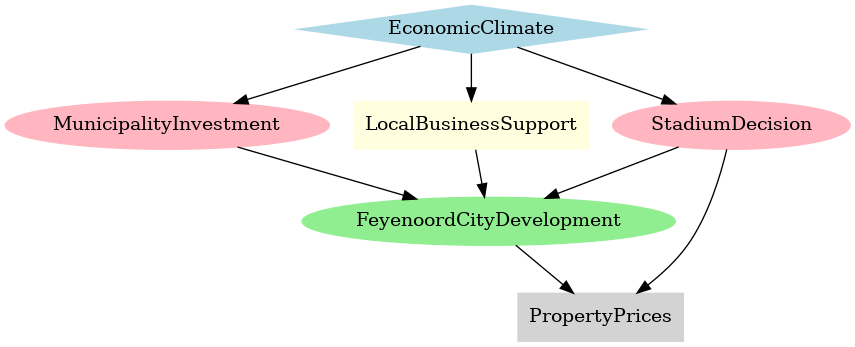

In [27]:
# G = ctx['graph']
# if 'graph' in ctx:
#     del ctx['graph']
# node_colors = {'treatment': 'lightcoral', 'outcome': 'lightgreen', 'confounder': 'lightblue', 'mediator': 'lightyellow', 'collider': 'lightgray'}
# colors = [node_colors[G.nodes[n]['type']] for n in G.nodes]
# plt.figure(figsize=(10, 6))
# pos = nx.circular_layout(G)
# nx.draw(G, pos, with_labels=True, node_color=colors, node_size=5000, font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)
# plt.title('Causal Graph', size=15);
# plt.tight_layout();

dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [28]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
print(ctx['prompt_stats'])

We have a causal bayes net based on the following article:

```
Title: Municipality of Rotterdam regarding Feyenoord City: 'Scenario taken into account when Feyenoord withdraws' - FR-Fans.nl
Description: The patience of the Municipality of Rotterdam has almost run out, according to Algemeen Dagblad. Councilor Van Gils wants to hear an answer from Feyenoord about whether there will be a new stadium. With or without a stadium, the area will be further developed.
Original Language: Dutch
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "EconomicClimate" is "Positive/Favorable" (rather than "Negative/Unfavorable")?
2. when "EconomicClimate" is "Negative/Unfavorable": what is the probability that "StadiumDecision" is "Construction" (rather than "No Construction")?
3. when "EconomicClimate" is "Positive/Favorable": what is the probability that "StadiumDecision" is "

In [29]:
# probabilities = ctx['stats']
#################################################

probabilities = {
  1: [0.4, 0.6],  # Neutral assumption for Economic Climate
  2: [0.2, 0.4],  # Lower probability under negative economic conditions
  3: [0.6, 0.8],  # Higher probability under positive economic conditions
  4: [0.3, 0.5],  # Less likely to invest under negative economic conditions
  5: [0.6, 0.8],  # More likely to invest under positive economic conditions
  6: [0.2, 0.4],  # Lower business support under negative economic conditions
  7: [0.6, 0.8],  # Higher business support under positive economic conditions
  8: [0.1, 0.3],  # Lower development probability under all negative conditions
  9: [0.3, 0.5],  # Slightly higher with positive business support
  10: [0.4, 0.6], # Higher with additional investment
  11: [0.5, 0.7], # Higher with positive business support and investment
  12: [0.3, 0.5], # Development less likely without construction, regardless of business support
  13: [0.4, 0.6], # Slightly higher with positive business support
  14: [0.5, 0.7], # Higher with additional investment
  15: [0.7, 0.9], # Highest with construction, investment, and business support
  16: [0.1, 0.3], # Property prices less likely to rise without construction or development
  17: [0.3, 0.5], # Slightly higher with area development
  18: [0.4, 0.6], # Higher with construction but no development
  19: [0.7, 0.9]  # Highest with construction and development
}



#################################################
ctx['stats'] = probabilities

In [31]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(50, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

------------------------  ------------------------  ---------------------  -------------------------------------------
StadiumDecision           No Construction           Construction           Decision on New Stadium Construction
MunicipalityInvestment    No Additional Investment  Additional Investment  Municipality's Investment in Infrastructure
FeyenoordCityDevelopment  No Development            Development            Development of Feyenoord City Area
------------------------  ------------------------  ---------------------  -------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

'EconomicClimate' means Economic Climate of Rotterdam
'StadiumDecision' means Decision on New Stadium Construction
'MunicipalityInvestment' means Municipality's Investment in Infrastructure
'LocalBusinessSupport' means Local Business Support
'FeyenoordCityDevelopment' means Development of Feyenoord City Area
'PropertyPrices' means Residential Property Prices
Treatment Value        Treatment               Outcome Value    Outcome                        ATE    Correlation
---------------------  ----------------------  ---------------  ------------------------  --------  -------------
Construction           StadiumDecision         Development      FeyenoordCityDevelopment  0.151098      0.215785
Additional Investment  MunicipalityInvestment  Development      FeyenoordCityDevelopment  0.251256     -0.0789807


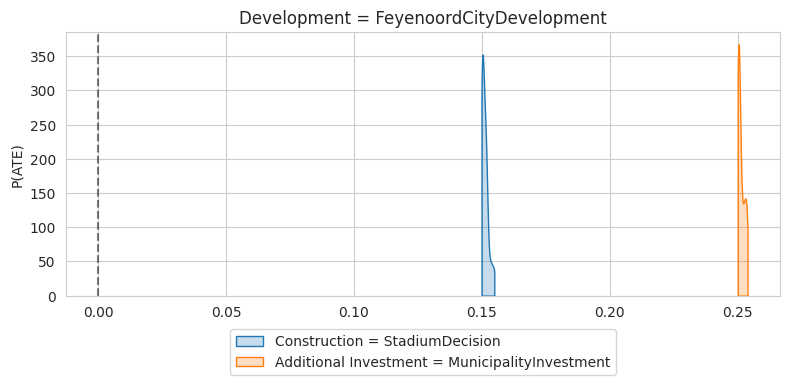

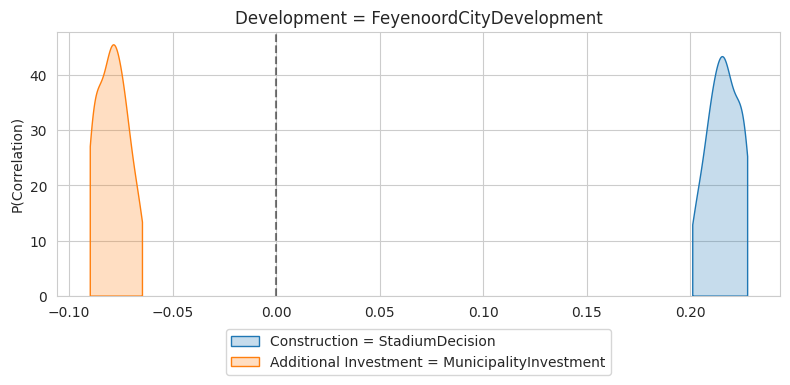

In [32]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

In [33]:
mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                       ATE    Correlation  Outcome
--------------------------------------------  -----  -------------  --------------------------------------------
Positive/Favorable EconomicClimate             0.4           -0.31  Construction StadiumDecision
Positive/Favorable EconomicClimate             0.3            0.48  Additional Investment MunicipalityInvestment
Positive/Favorable EconomicClimate             0.4            0.03  High/Positive LocalBusinessSupport
Positive/Favorable EconomicClimate             0.2           -0.09  Development FeyenoordCityDevelopment
Positive/Favorable EconomicClimate             0.2           -0.03  Rising/High PropertyPrices
Construction StadiumDecision                   0             -0.31  Positive/Favorable EconomicClimate
Construction StadiumDecision                   0             -0.15  Additional Investment MunicipalityInvestment
Construction StadiumDecision                   0             -0.01  High/Positive 

In [83]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('Brain Stimulation Activities', 'Cognitive Decline', [])
('Physical Exercise', 'Cognitive Decline', ['Age'])


In [34]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {variable}.
2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
3. There is a [number]% chance that {value}.
4. [number]% of {domain} {value}.
5. [number]% of the time {value}.
6. Conditional sentence: {value}, [some consequence].
7. Interventional: If {value}, [some effect].

Variable 'EconomicClimate' (0='Negative/Unfavorable', 1='Positive/Favorable') means Economic Climate of Rotterdam
Variable 'StadiumDecision' (0='No Construction', 1='Construction') means Decision on New Stadium Construction
Variable 'MunicipalityInvestment' (0='No 

In [35]:
# verbalizations = ctx['verbs']
#######################################################################

verbalizations = {
  "EconomicClimate": {
    1: {"variable": ["the economic climate in Rotterdam", "Rotterdam's economic outlook"]},
    2: {"subject": "Rotterdam", "value": {0: ["faces economic challenges", "is experiencing a tough economic period"], 1: ["is enjoying a favorable economic climate", "is in a period of economic prosperity"]}},
    3: {"value": {0: ["the economic climate is unfavorable", "there are economic struggles"], 1: ["the economic climate is favorable", "the economy is thriving"]}},
    4: {"domain": "times", "value": {0: ["the economic climate is challenging", "there are economic difficulties"], 1: ["the economic climate is positive", "the economy is flourishing"]}},
    5: {"value": {0: ["the economy faces downturns", "economic struggles are evident"], 1: ["the economy is booming", "economic prosperity is visible"]}},
    6: {"value": {0: ["When the economy is struggling", "In times of economic hardship"], 1: ["When the economy is strong", "During economic prosperity"]}},
    7: {"value": {0: ["if the economic climate worsens", "if economic struggles continue"], 1: ["if the economic climate improves", "if the economy grows stronger"]}}
  },
  "StadiumDecision": {
    1: {"variable": ["the stadium construction decision", "the verdict on building a new stadium"]},
    2: {"subject": "The city", "value": {0: ["decides against building the stadium", "opts not to construct the stadium"], 1: ["decides to build the stadium", "opts for stadium construction"]}},
    3: {"value": {0: ["the stadium is not built", "there is no new stadium construction"], 1: ["the stadium is built", "a new stadium is constructed"]}},
    4: {"domain": "cases", "value": {0: ["the stadium isn't built", "no new stadium construction happens"], 1: ["the stadium is constructed", "a new stadium rises"]}},
    5: {"value": {0: ["no stadium construction takes place", "the stadium plans are shelved"], 1: ["stadium construction goes ahead", "the new stadium is built"]}},
    6: {"value": {0: ["If the stadium isn't built", "Without new stadium construction"], 1: ["If the stadium is constructed", "With the new stadium being built"]}},
    7: {"value": {0: ["if the decision is against stadium construction", "if building the stadium is declined"], 1: ["if the decision is to build the stadium", "if there's a green light for the stadium"]}}
  },
  "MunicipalityInvestment": {
    1: {"variable": ["the municipality's investment in infrastructure", "the city's infrastructure spending"]},
    2: {"subject": "The municipality", "value": {0: ["holds back on infrastructure investment", "does not increase infrastructure spending"], 1: ["boosts infrastructure investment", "increases spending on infrastructure"]}},
    3: {"value": {0: ["no additional investment in infrastructure", "infrastructure spending remains unchanged"], 1: ["additional investment in infrastructure", "increased infrastructure spending"]}},
    4: {"domain": "situations", "value": {0: ["no increase in infrastructure spending", "infrastructure investment is static"], 1: ["an increase in infrastructure spending", "a boost in infrastructure investment"]}},
    5: {"value": {0: ["infrastructure investment remains the same", "no new funding for infrastructure"], 1: ["infrastructure investment grows", "new funding for infrastructure is allocated"]}},
    6: {"value": {0: ["Without increased infrastructure spending", "If there's no new investment in infrastructure"], 1: ["With additional investment in infrastructure", "If infrastructure spending is increased"]}},
    7: {"value": {0: ["if the municipality does not invest more", "if there's no increase in infrastructure funding"], 1: ["if the municipality boosts its investment", "if more funds are allocated to infrastructure"]}}
  },
  "LocalBusinessSupport": {
    1: {"variable": ["local business support", "support from local businesses"]},
    2: {"subject": "Local businesses", "value": {0: ["show limited support", "are not very supportive"], 1: ["offer strong support", "are highly supportive"]}},
    3: {"value": {0: ["limited support from local businesses", "a lack of enthusiasm among local businesses"], 1: ["strong support from local businesses", "enthusiastic backing from local businesses"]}},
    4: {"domain": "instances", "value": {0: ["local businesses are not supportive", "there's little support from local businesses"], 1: ["local businesses are supportive", "there's strong support from local businesses"]}},
    5: {"value": {0: ["support from local businesses is low", "little enthusiasm from local businesses"], 1: ["support from local businesses is high", "significant backing from local businesses"]}},
    6: {"value": {0: ["When local businesses are not supportive", "If local business support is lacking"], 1: ["When local businesses are supportive", "If there is strong local business support"]}},
    7: {"value": {0: ["if local businesses do not offer support", "if there's little backing from local businesses"], 1: ["if local businesses are supportive", "if local businesses rally behind the project"]}}
  },
  "FeyenoordCityDevelopment": {
    1: {"variable": ["the development of Feyenoord City area", "Feyenoord City's development"]},
    2: {"subject": "The project", "value": {0: ["does not proceed", "stalls"], 1: ["moves forward", "progresses"]}},
    3: {"value": {0: ["no development in Feyenoord City", "Feyenoord City's development stalls"], 1: ["development in Feyenoord City", "Feyenoord City's development progresses"]}},
    4: {"domain": "occasions", "value": {0: ["the development does not happen", "there's no progress in development"], 1: ["the development takes place", "there's notable progress"]}},
    5: {"value": {0: ["the area remains undeveloped", "development is at a standstill"], 1: ["the area is developed", "development moves forward"]}},
    6: {"value": {0: ["If the area doesn't develop", "Without development in Feyenoord City"], 1: ["If the area develops", "With development in Feyenoord City"]}},
    7: {"value": {0: ["if development in Feyenoord City does not occur", "if the project stalls"], 1: ["if Feyenoord City undergoes development", "if the development project moves forward"]}}
  },
  "PropertyPrices": {
    1: {"variable": ["property prices", "the real estate market"]},
    2: {"subject": "The housing market", "value": {0: ["remains stable", "does not see major changes"], 1: ["sees rising prices", "experiences a surge"]}},
    3: {"value": {0: ["property prices are stable", "no significant change in real estate values"], 1: ["property prices are rising", "a surge in real estate values"]}},
    4: {"domain": "scenarios", "value": {0: ["property prices stay the same", "real estate values don't change much"], 1: ["property prices rise", "there's an increase in real estate values"]}},
    5: {"value": {0: ["stable property prices", "unchanged real estate market"], 1: ["rising property prices", "a booming real estate market"]}},
    6: {"value": {0: ["If property prices remain stable", "When the real estate market doesn't change"], 1: ["If property prices rise", "When the real estate market surges"]}},
    7: {"value": {0: ["if property prices do not increase", "if the real estate market remains unchanged"], 1: ["if property prices go up", "if the real estate market experiences a boom"]}}
  }
}


#######################################################################
ctx['verbs'] = verbalizations

In [36]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
print(ctx['prompt_questions'])

We have a causal bayes net based on the following article:

```
Title: Municipality of Rotterdam regarding Feyenoord City: 'Scenario taken into account when Feyenoord withdraws' - FR-Fans.nl
Description: The patience of the Municipality of Rotterdam has almost run out, according to Algemeen Dagblad. Councilor Van Gils wants to hear an answer from Feyenoord about whether there will be a new stadium. With or without a stadium, the area will be further developed.
Original Language: Dutch
```

Now we would like to use this model to generate some interesting research questions:

1. Write a short two sentence introduction to describe motivation and purpose of the causal model to provide context to the questions in an conversational/debate setting. Where possible, include relevant details from the original article headline or related information you can infer therefrom. Avoid discussing specific structural properties or assumptions in the causal graph, and instead focus on the overall motivat

In [37]:
# setting = ctx['questions']
#######################################################################

setting = {
  "introduction": "In the vibrant city of Rotterdam, the debate around Feyenoord City's development, including the construction of a new stadium, has garnered significant attention. This situation presents an intriguing opportunity to explore how various decisions and factors might influence the city's development and economic landscape.",
  "overview": "Our exploration revolves around understanding how different elements like the decision to build a new stadium, the city's investment in infrastructure, and the economic climate of Rotterdam interact with each other. We're particularly interested in how these elements together impact the development of Feyenoord City and the local real estate market, keeping in mind that some factors can influence or be influenced by multiple elements in this scenario.",
  "questions": {
    1: {
      "question": "Is the decision to build a new stadium in Rotterdam likely to have a negative impact on the city's development?",
      "answer": "yes",
      "explanation": "Building a new stadium is expected to negatively influence the city's development due to the significant resources and focus it requires, potentially diverting attention and funds from other developmental aspects.",
      "wrong_explanation": "Building a new stadium is expected to positively influence the city's development as it can attract more visitors and investment, boosting the overall growth."
    },
    2: {
      "question": "Does investing more in the city's infrastructure positively impact Feyenoord City's development?",
      "answer": "yes",
      "explanation": "Increased investment in infrastructure by the municipality is likely to have a positive impact on Feyenoord City's development, enhancing accessibility and attractiveness of the area.",
      "wrong_explanation": "Increased investment in infrastructure might overburden the city's budget, leaving fewer resources for the development of Feyenoord City."
    },
    3: {
      "question": "Is the impact of investing in infrastructure on Feyenoord City's development lesser than that of the decision to build a new stadium?",
      "answer": "yes",
      "explanation": "The decision to build a new stadium likely has a more substantial impact on the city's development than infrastructure investment, given its scale and the attention it draws.",
      "wrong_explanation": "Investing in infrastructure is expected to have a more significant impact on the city's development than the stadium construction, as it affects a broader range of city areas and services."
    },
    4: {
      "question": "Is the absolute impact of the stadium decision on Feyenoord City's development greater than that of the municipality's investment in infrastructure?",
      "answer": "yes",
      "explanation": "The decision to build or not build a new stadium has a more pronounced and direct impact on the city's development compared to the more distributed and less visible effects of infrastructure investment.",
      "wrong_explanation": "The municipality's investment in infrastructure is likely to have a more far-reaching and significant impact on the city's development than the decision related to a single stadium project."
    },
    5: {
      "question": "When Rotterdam's economic climate is unfavorable, does the decision to build a new stadium still positively impact Feyenoord City's development?",
      "answer": "yes",
      "explanation": "Even in a challenging economic climate, the construction of a new stadium could provide a positive boost to Feyenoord City's development through increased attention and potential economic stimulation.",
      "wrong_explanation": "In an unfavorable economic climate, the resources required for a new stadium could further strain the city's development efforts, making the impact negative."
    },
    6: {
      "question": "In a challenging economic climate, does increasing the city's infrastructure investment positively impact Feyenoord City's development?",
      "answer": "yes",
      "explanation": "Enhancing infrastructure investment during tough economic times can provide a positive lift to the city's development by improving essential services and accessibility.",
      "wrong_explanation": "When the economic climate is negative, additional investment in infrastructure might not be effective due to financial constraints and reduced overall economic activity."
    },
    7: {
      "question": "In an unfavorable economic climate, does the decision to build a new stadium have a greater positive impact on Feyenoord City's development compared to increasing infrastructure investment?",
      "answer": "yes",
      "explanation": "The construction of a new stadium is likely to have a more noticeable and immediate positive effect on the city's development than infrastructure investment, especially in a challenging economic environment.",
      "wrong_explanation": "In tough economic times, the practical benefits of enhanced infrastructure investment are expected to outweigh the impact of a new stadium in driving the city's development."
    },
    8: {
      "question": "Is the absolute impact of increasing infrastructure investment in a challenging economic climate less than that of deciding to build a new stadium?",
      "answer": "yes",
      "explanation": "The direct and visible impact of a new stadium construction tends to overshadow the more subtle, yet essential, benefits of infrastructure investment, especially in an unfavorable economic setting.",
      "wrong_explanation": "Infrastructure investment, even in a difficult economic climate, can have a more significant and lasting impact on the city's development compared to the one-off decision of building a stadium."
    },
    9: {
      "question": "When Rotterdam's economic climate is favorable, does the decision to build a new stadium still positively impact Feyenoord City's development?",
      "answer": "yes",
      "explanation": "In a positive economic environment, the construction of a new stadium can complement the city's growth momentum, adding to the overall development of Feyenoord City.",
      "wrong_explanation": "With a thriving economy, resources spent on a new stadium might be seen as redundant or less impactful for the city's development."
    },
    10: {
      "question": "In a favorable economic climate, does increasing the city's infrastructure investment negatively impact Feyenoord City's development?",
      "answer": "no",
      "explanation": "Infrastructure investment in a thriving economic climate is likely to further bolster the city's development, complementing the existing positive momentum.",
      "wrong_explanation": "Additional investment in infrastructure during favorable economic times might be inefficient or lead to overspending, negatively affecting the city's development."
    },
    11: {
      "question": "In a positive economic climate, is the impact of investing in infrastructure on Feyenoord City's development lesser than that of the decision to build a new stadium?",
      "answer": "yes",
      "explanation": "The construction of a new stadium typically represents a landmark development, having a more pronounced impact on the city's growth than infrastructure investment, even in good economic times.",
      "wrong_explanation": "In a favorable economic climate, the systematic improvements from infrastructure investment could be more influential for the city's development than a single large-scale project like a stadium."
    },
    12: {
      "question": "Is the absolute impact of infrastructure investment in a favorable economic climate greater than that of the stadium decision?",
      "answer": "no",
      "explanation": "Even in a healthy economy, the tangible and high-profile nature of a new stadium construction often has a more immediate and visible impact compared to the gradual benefits of infrastructure investment.",
      "wrong_explanation": "In a positive economic setting, the strategic importance and widespread benefits of infrastructure investment can surpass the impact of a new stadium project on the city's development."
    },
    13: {
      "question": "Does the decision to build a new stadium have a greater positive impact on Feyenoord City's development in a favorable economic climate compared to an unfavorable one?",
      "answer": "yes",
      "explanation": "A new stadium, built in a thriving economic environment, is likely to complement and amplify the city's existing growth, making its impact more significant compared to during economic downturns.",
      "wrong_explanation": "In an unfavorable economic climate, the construction of a new stadium might be seen as a much-needed boost, potentially having a greater impact than in times of economic prosperity."
    },
    14: {
      "question": "Is the impact of building a new stadium more significant in an unfavorable economic climate compared to a favorable one?",
      "answer": "no",
      "explanation": "The positive effects of a new stadium are typically more pronounced in a healthy economic environment, where it can add to existing growth, rather than in a struggling economy.",
      "wrong_explanation": "In challenging economic times, the construction of a new stadium might be viewed as a critical driver of development, having a greater impact than in a stable economy."
    },
    15: {
      "question": "Is increasing infrastructure investment more beneficial for Feyenoord City's development during economic hardship than in times of economic prosperity?",
      "answer": "no",
      "explanation": "Infrastructure investment tends to yield better results in a positive economic climate, where it can build on existing momentum, rather than in times of economic struggle.",
      "wrong_explanation": "During economic downturns, focused investment in infrastructure might be critical to sustaining or kick-starting the city's development, making it more beneficial than in times of prosperity."
    },
    16: {
      "question": "Is the impact of increased infrastructure investment more substantial in a favorable economic climate compared to an unfavorable one?",
      "answer": "yes",
      "explanation": "The benefits of increased infrastructure investment are typically more pronounced in a thriving economy, where they can leverage and enhance existing growth.",
      "wrong_explanation": "In a struggling economy, strategic infrastructure investment might be crucial to maintain or stimulate development, hence having a more significant impact compared to in a strong economy."
    }
  },
}



#######################################################################
ctx['questions'] = setting

In [38]:
i = len(list(ctx._root.glob("*.json")))+1
path = ctx._root / f'test{i}'
while path.exists():
    i += 1
    path = ctx._root / f'test{i}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id)

PosixPath('/home/fleeb/workspace/code/cladder/novo-data/stories/test20.json')

In [58]:
ctx['stats'] = {int(k): v for k, v in ctx['stats'].items()}
ctx['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in ctx['verbs'].items()}
for k, v in ctx['verbs'].items():
    for k2, v2 in v.items():
        if 'value' in v2:
            v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
ctx['questions']['questions'] = {int(k): v for k, v in ctx['questions']['questions'].items()}

In [59]:
rawverbs = ctx['verbs']
rawvars = {node['name']: node for node in ctx['nodes']}

In [60]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('Refinery Safety Protocols', 'Human Casualties', ['Emergency Response Efficiency'])
('Emergency Response Efficiency', 'Human Casualties', ['Refinery Safety Protocols'])


In [61]:
qkey = random.choice(list(ctx['questions']['questions']))
qkey = 3
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][qkey-1]
print(ctx['query_description'].split('\n')[qkey-1])
print(query)
qinfo

	3. ATE('Refinery Safety Protocols') < ATE('Emergency Response Efficiency')
{'treatment1': 'Refinery Safety Protocols', 'treatment2': 'Emergency Response Efficiency', 'query': 'ate', 'type': 'ate-compare', 'criterion': '<'}


{'question': 'Are the benefits of efficient emergency response greater than those of having adequate safety protocols in preventing casualties?',
 'answer': 'no',
 'explanation': 'While both are important, adequate safety protocols typically have a more direct impact on preventing casualties than the efficiency of emergency response.',
 'wrong_explanation': 'The efficiency of emergency response is generally more crucial than safety protocols in reducing casualties.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [63]:
next(iter(rawverbs.values()))

{1: {'variable': ['the age of the refinery',
   'how long the refinery has been operational']},
 2: {'subject': 'the refinery',
  'value': {0: ['is a new facility', 'has been recently established'],
   1: ['has been operating for many years', 'is an older establishment']}},
 3: {'value': {0: ['the refinery is newly built',
    'the refinery has been recently established'],
   1: ['the refinery is quite old',
    'the refinery has many years of operation']}},
 4: {'domain': 'refineries',
  'value': {0: ['are new establishments', 'have been recently built'],
   1: ['are older facilities', 'have been operating for many years']}},
 5: {'value': {0: ['the refinery is a new establishment',
    'the refinery has been recently constructed'],
   1: ['the refinery is an old establishment',
    'the refinery has been operating for a long time']}},
 6: {'value': {0: ['If the refinery is newly established',
    'In newer refineries'],
   1: ['If the refinery has been around for many years',
    'In

In [ ]:
varverbs = {}

for var, raw in rawverbs.items():
    info = {'values': {0: {}, 1: {}}}
    info0 = info['values'][0]
    info1 = info['values'][1]
    
    info['variable'] = raw[1]['variable']
    info['subject'] = raw[2]['subject']
    info['domain'] = raw[3]['domain']
    
    
    
    for i in [0, 1]:
        info_val = raw[2]['value'][i]
        info_val['verb'] = raw[2]['value'][i]
        

    varverbs[var] = info

In [62]:
rawverbs[treatment1['name']]

{1: {'variable': ['the safety protocols in place at the refinery',
   'how well the refinery follows safety guidelines']},
 2: {'subject': 'the refinery',
  'value': {0: ['lacks adequate safety protocols',
    'has insufficient safety measures'],
   1: ['maintains adequate safety protocols', 'has robust safety measures']}},
 3: {'value': {0: ['safety protocols are inadequate',
    'safety measures are not up to standard'],
   1: ['safety protocols are thoroughly implemented',
    'safety measures are comprehensive']}},
 4: {'domain': 'refineries',
  'value': {0: ['lack adequate safety measures',
    'do not follow safety guidelines properly'],
   1: ['have robust safety protocols',
    'adhere strictly to safety guidelines']}},
 5: {'value': {0: ['safety protocols are not followed properly',
    'safety measures are neglected'],
   1: ['safety protocols are strictly followed',
    'safety measures are taken seriously']}},
 6: {'value': {0: ['If safety protocols are lacking',
    'In re

In [28]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
example_tmpl = '{subject} often {value}.'

In [35]:
rawverbs

{'Presidential Engagement in Climate Discussions': {'1': {'variable': ['presidential involvement in climate talks',
    "the president's active participation in climate discussions"]},
  '2': {'subject': 'the president',
   'value': {'0': ['is not involved in climate discussions',
     'does not engage in climate talks'],
    '1': ['actively participates in climate discussions',
     'is deeply involved in climate talks']}},
  '3': {'value': {'0': ['the president is not engaged in climate talks',
     'there is no presidential involvement in climate discussions'],
    '1': ['the president is actively engaged in climate talks',
     'there is direct presidential involvement in climate discussions']}},
  '4': {'domain': 'instances of climate discussions',
   'value': {'0': ['do not include presidential engagement',
     "lack the president's involvement"],
    '1': ['include active presidential participation',
     "feature the president's active involvement"]}},
  '5': {'value': {'0': [

In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args